# Custom LSTM cell with probabilistic activation functions

In [1]:
'''
Trains an LSTM model, using probabilistic activation functions as described in this paper:
https://paperswithcode.com/paper/probact-a-probabilistic-activation-function

To use such custom activation function, a custom LSTM cell has to be implemented.
For this, I will use code modified from this file:
https://github.com/pytorch/pytorch/blob/main/benchmarks/fastrnns/custom_lstms.py

I store both implementations in the "models" folder.

The task and the original code which I have modified for this notebook comes from the following tutorial:
https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
where the task is defined like this:
"The problem you will look at in this post is the international airline passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000."
The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

The data is downloade from here:
https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

''';

### Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

### Define general variables 

In [3]:
#proportion of data used for training
prop_train = 2/3

### Fetch data 

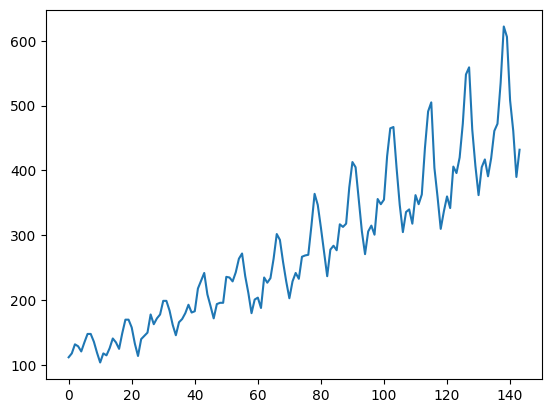

In [4]:
data_folder = './data/'
data_file = 'airline_passengers.csv'

numpass_type = 'float32' # to convert the number of passengers from int to float

df = pd.read_csv(data_folder + data_file)
time_series = df[["Passengers"]].values.astype(numpass_type)

# see how data looks like and whether it makes sense
plt.plot(time_series)
plt.show()

In [5]:
# train-test split the time series
train_size = int(len(time_series) * prop_train)
test_size = len(time_series) - train_size
train, test = time_series[:train_size], time_series[train_size:]

In [6]:
# create a function to generate a dataset of fixed window from a time series
lookback = 4 # number of time steps to be fed to the model
def create_dataset(dataset, lookback):
    '''
    Transforms a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    '''
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    num_features = train.shape[1]
    num_samples = len(dataset)-lookback
    X, y = np.empty((num_samples,lookback,num_features), dtype=numpass_type), np.empty((num_samples,lookback,num_features), dtype=numpass_type)
    
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1] # Should the target include the full window? Does it make any difference?
        #target = dataset[i+lookback] # this does not include the full window in the target
        #y[i] = [target] # this does not include the full window in the target
        X[i] = feature # this includes the full window in the target
        y[i] = target # this includes the full window in the target

    return torch.tensor(X).to(device), torch.tensor(y).to(device)

In [7]:
# create_dataset is designed to convert a time series into a tensor of dimensions: 
# (number of samples, time steps, features)
# num_samples = number of sub-series; time steps = length of sub-serie
# ergo: num_samples = len(data set) - lookback; time_steps = lookback

X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
''' 
# Some numbers and examples to understand dimensionalities:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(train.ndim)
print(len(train),len(train[0]))
print(X_train[:5])
''';

## Probabilistic LSTM 

### Import the custom LSTM and probabilistic activation 

In [8]:
from models import custom_lstms, probact

/home/gabrielmadirolas/pytorch_env/pytorch_env/lib/python3.12/site-packages/torch/jit/_recursive.py:313: UserWarning: 'layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
/home/gabrielmadirolas/pytorch_env/pytorch_env/lib/python3.12/site-packages/torch/jit/_recursive.py:313: UserWarning: 'directions' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(


### Define variables 

In [30]:
# number of LSTM layers CORRECT THIS to be introduced in the num_layers variable of nn.LSTM

num_features = X_train.shape[2] # number of features of each data point
hidden_size = 50 # size of layer in LSTM cell
n_LSTM = 1 # number of LSTM cells used
dropout = 0.0
batch_size = 8
batch_first = True # first dimension runs across batches, second is the sequence length (num of time steps)

lr = 0.001 # Gab: was 0.01
# Initialization parameters of the probabilistic activation function (probact)
init_params = {
'mean_mu':0.0,
'std_mu':0.0,
'mean_sigma':0.5,
'std_sigma':0.5,
# to use a sigmoid for sigma, set the two following to different than 0.0
# Both are set as non-trainable in the probact.py file
'alpha':0.0, # must not be integer
'beta':0.0 # must not be integer
}

### Define model

In [31]:
# Build the LSTM model to predict the time series. With lookback=1, accuracy won't be great
# The model is created as a class, with a LSTM layer and a fully-connected layer


class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = custom_lstms.prob_lstm(num_features=num_features, hidden_size=hidden_size, num_layers=n_LSTM, 
                     bias=True, bidirectional=False, dropout=dropout, batch_first=batch_first)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x, states = self.lstm(x) 
        x = self.linear(x)
        return x # remeber that the prediction is the last time step of this output
'''The output of prob_lstm() is a tuple. The first element is the generated hidden states [from the last LSTM layer],
one for each time step of the input. 
The second element is the LSTM cell’s memory and hidden states [for all LSTM layers], which is not used here. 
''';

In [32]:
test_model = AirModel()
print(test_model.lstm)
print(test_model.linear)

dropout 0.0
MyStackedLSTMWithDropout(
  (layers): RecursiveScriptModule(
    original_name=ModuleList
    (0): LSTMLayer(
      (cell): ProbLSTMCell(
        (sigma): EWTrainableMuSigma(num_parameters=[200])
      )
    )
  )
  (dropout_layer): RecursiveScriptModule(original_name=Dropout)
)
Linear(in_features=50, out_features=1, bias=True)


### Train the LSTM network

In [33]:
'''
Because it is a regression problem, MSE is chosen as the loss function.
PyTorch tensors will be combined into a dataset using torch.utils.data.TensorDataset
Batch for training is provided by a DataLoader
'''

torch.backends.cudnn.benchmark = True # this is not improving performance, nor changing runtime

model = AirModel()

if not os.path.exists('checkpoints'):
    os.mkdir('checkpoints')
saved_model_path = './checkpoints/saved_model.pth'

resume = False
if resume:
    print(f'==> Resuming from {saved_model_path}')
    model.load_state_dict(torch.load(saved_model_path))

optimizer = optim.Adam(model.parameters(),lr=lr)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu') # for tests
model.to(device)
print("The model is on the GPU:",next(model.parameters()).is_cuda) # checks whether the model is on cuda
start_time = time.time()

print('lr',lr)
n_epochs = 2
for epoch in range(n_epochs+1):
    model.train()
    #print(model)
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch)
        y_pred = torch.swapaxes(y_pred,0,1) # prob_lstm returns batch second
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        y_pred = model(X_train)
        y_pred = torch.swapaxes(y_pred,0,1) # prob_lstm returns batch second
        train_rmse = np.sqrt(loss_fn(y_pred, y_train).cpu())
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_pred = model(X_test)
        y_pred = torch.swapaxes(y_pred,0,1) # prob_lstm returns batch second
        test_rmse = np.sqrt(loss_fn(y_pred, y_test).cpu())
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

torch.save(model.state_dict(), saved_model_path)

print("--- %s seconds ---" % (time.time() - start_time))

dropout 0.0
The model is on the GPU: True
lr 0.001
Epoch 0: train RMSE 226.3624, test RMSE 425.6044
--- 0.11559319496154785 seconds ---


### Verify the network

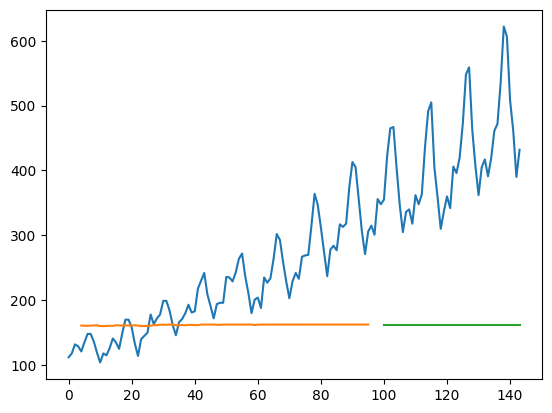

In [13]:
'''
It is expected to see the RMSE of test set is about an order of magnitude larger. 
The RMSE of 100 means the prediction and the actual target would be
in average off by 100 in value (i.e., 100,000 passengers in this dataset).
To better understand the prediction quality, let's plot the output using matplotlib
'''
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(time_series) * np.nan
    train_plot[lookback:train_size] = model(X_train)[-1, :, :].cpu() # remember that prob_lstm returns batch second
    # shift test predictions for plotting
    test_plot = np.ones_like(time_series) * np.nan
    test_plot[train_size+lookback:len(time_series)] = model(X_test)[-1, :, :].cpu() # remember that prob_lstm returns batch second
# plot
plt.plot(time_series)
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()

In [14]:
t = torch.empty(3, 5, 2)
ts = t.size()
print(ts)
print(ts[2])

batch, seq_len, num_features = ts[:]
print(batch, seq_len, num_features)

torch.Size([3, 5, 2])
2
3 5 2


In [15]:
batch_first = torch.tensor([[[0,1],[2,3],[4,5],[6,7],[8,9]],[[10,11],[12,13],[14,15],[16,17],[18,19]],[[20,21],[22,23],[24,25],[26,27],[28,29]]])
print(batch_first.size())
batch_second = torch.swapaxes(batch_first,0,1)
print(batch_second.size())
print(batch_second)

torch.Size([3, 5, 2])
torch.Size([5, 3, 2])
tensor([[[ 0,  1],
         [10, 11],
         [20, 21]],

        [[ 2,  3],
         [12, 13],
         [22, 23]],

        [[ 4,  5],
         [14, 15],
         [24, 25]],

        [[ 6,  7],
         [16, 17],
         [26, 27]],

        [[ 8,  9],
         [18, 19],
         [28, 29]]])


In [16]:
4 + 10 % 2

4

In [17]:
# Simple test model
class SimpleModel(torch.nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = torch.nn.Linear(10, 10)

    def forward(self, x):
        return self.fc(x)

# Create model and data
model = SimpleModel().to(device)
X_batch = torch.randn(32, 10).to(device)  # Random input tensor, already on device

y_pred = model(X_batch)  # Try running it
print(y_pred.device)  # This should print 'cuda:0'

cuda:0
